# Test out Feature engine Pipeline functions

In [101]:
# import statements

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.pipeline import Pipeline
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
warnings.filterwarnings('ignore')
import scipy.stats as stats

In [103]:
#Utility functions for cleaning datasets from CodeInstitute LMS

In [104]:
def DataCleaningEffect(df_original, df_cleaned, variables_applied_with_method):
    """
    This function compares the distribution of variables before and after data cleaning.

    Parameters:
    df_original (DataFrame): The original DataFrame before cleaning.
    df_cleaned (DataFrame): The DataFrame after cleaning.
    variables_applied_with_method (list): The list of variables that the cleaning method was applied to.
    """

    flag_count = 1  # Counter to keep track of the plot number

    # Identify categorical variables in the original DataFrame
    categorical_variables = df_original.select_dtypes(exclude=['number']).columns

    # Loop over the variables that the cleaning method was applied to
    for set_of_variables in [variables_applied_with_method]:
        print("\n=====================================================================================")
        print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
        print(f"{set_of_variables} \n\n")

        # For each variable, plot its distribution before and after cleaning
        for var in set_of_variables:
            if var in categorical_variables:  # If the variable is categorical, use a barplot
                # Create DataFrames for the original and cleaned data
                df1 = pd.DataFrame({"Type": "Original", "Value": df_original[var]})
                df2 = pd.DataFrame({"Type": "Cleaned", "Value": df_cleaned[var]})
                # Concatenate the two DataFrames
                dfAux = pd.concat([df1, df2], axis=0).reset_index()
                # Create the plot
                fig, axes = plt.subplots(figsize=(15, 5))
                sns.countplot(hue='Type', data=dfAux, x="Value", palette=['#432371', "#FAAE7B"])
                axes.set(title=f"Distribution Plot {flag_count}: {var}")
                plt.xticks(rotation=90)
                plt.legend()

            else:  # If the variable is numerical, use a histogram
                # Create the plot
                fig, axes = plt.subplots(figsize=(10, 5))
                sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True, element="step", ax=axes)
                sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True, element="step", ax=axes)
                axes.set(title=f"Distribution Plot {flag_count}: {var}")
                plt.legend()

In [105]:

#More feature engineering functions


In [106]:
def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions

    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop over each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respectives column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    # Check analyis type
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is missing values in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    # Set suffix colummns acording to analysis_type
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers

def apply_transformers(analysis_type, df_feat_eng, column):

    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers

def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(20, 5))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")

def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

def FeatEngineering_Numerical(df_feat_eng, column):

    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked




In [107]:
#import planets dataset from seaborn
planet_data = sns.load_dataset("planets")
planet_data.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


In [108]:
mass_index = planet_data[(planet_data['distance'] > 2000)].index
planet_data.drop(mass_index, inplace=True)
orbital_index = planet_data[(planet_data['orbital_period'] > 10000)].index
planet_data.drop(orbital_index, inplace=True)

In [109]:
planet_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 0 to 1034
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   method          1004 non-null   object 
 1   number          1004 non-null   int64  
 2   orbital_period  970 non-null    float64
 3   mass            510 non-null    float64
 4   distance        781 non-null    float64
 5   year            1004 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 54.9+ KB


In [110]:
planet_data.isna().sum()

method              0
number              0
orbital_period     34
mass              494
distance          223
year                0
dtype: int64

In [111]:
from feature_engine.imputation import MeanMedianImputer


In [112]:
variables_methods = ['distance', 'orbital_period']
imputer = MeanMedianImputer(
    variables=variables_methods,
    imputation_method='median'
)
df_method = imputer.fit_transform(planet_data)


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['distance', 'orbital_period'] 




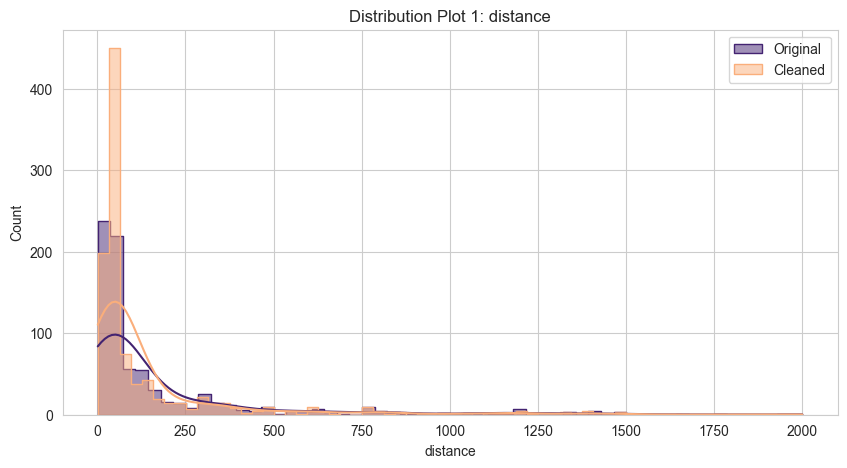

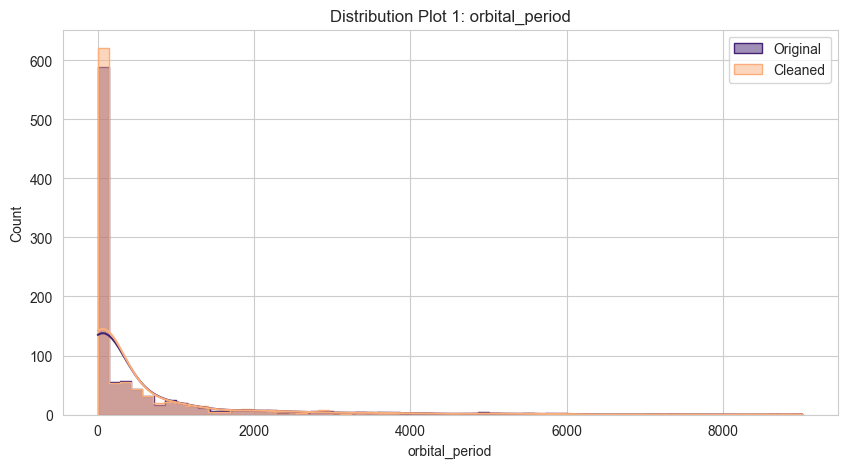

In [113]:
DataCleaningEffect(df_original=planet_data, df_cleaned=df_method, variables_applied_with_method=variables_methods)